##### assess at least three categories of intensity: background, nuclear plasma, nucleolar region

In [1]:
import numpy as np
import os
from skimage import io
import cv2
import re
import glob
import matplotlib.pyplot as plt
from Import_Functions import import_imgs


# packages for segmenting images
import seg_util as su
import imageio
from skimage.measure import label, regionprops,find_contours
# 
from scipy.ndimage import gaussian_filter

#
import nucleolus_processing_imgs as npi
from skimage import morphology
from scipy import ndimage as ndi

In [17]:
# read image
folder = r"C:\Users\Laga Ash\Desktop\map_to_each_worm_training_good_data\20220710_L4\2_1"
raw_img = import_imgs(folder, "Composite_stack.tif")
nucleus = import_imgs(folder, "nuclei_mask.tif")
background = import_imgs(folder, "background_mask.tif")
hole_filled = import_imgs(folder, "hole_filled.tif")

max_projection = np.stack([ np.max(raw_img[...,i], axis=0) for i in range(raw_img.shape[-1])], axis=-1)
hole_max = np.max(hole_filled, axis=0)

In [18]:
# get contours for each region
contours_bg = find_contours(background[0,...],0.1)
contours_nucleus = find_contours(nucleus[0,...],0.1)
contours_hole_filled = find_contours(hole_max[...],0.1)


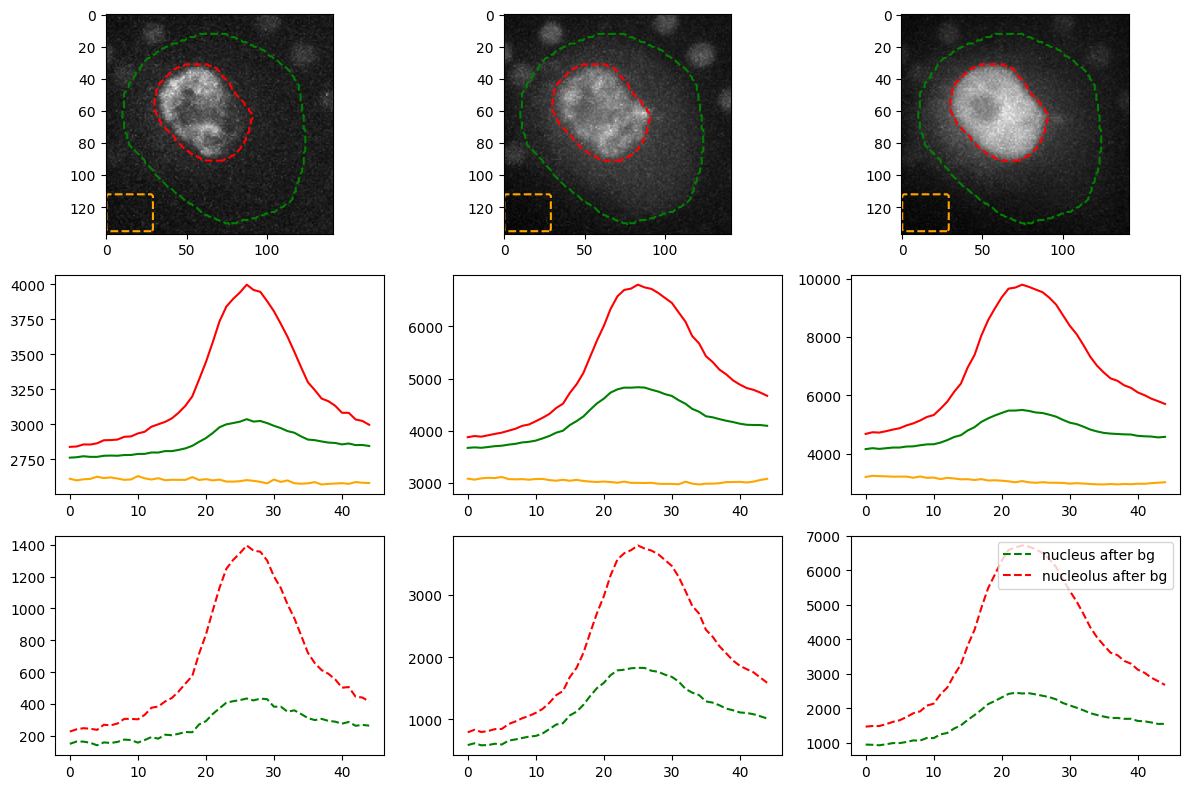

In [22]:
# plot images and mean intensity of each region across each slice
fig,axs = plt.subplots(3,3,figsize=(12,8))
colors = ["orange","green","red"]
for i in range(raw_img.shape[-1]):
    # plot max projection and contours
    axs[0, i].imshow(max_projection[...,i],cmap="gray")
    # outline  contours
    for contour in contours_bg:
        axs[0, i].plot(contour[:,1],contour[:,0],color=colors[0],linestyle="dashed",label="background")
    for contour in contours_nucleus:
        axs[0, i].plot(contour[:,1],contour[:,0],color=colors[1],linestyle="dashed",label="nucleus")
    for contour in contours_hole_filled:
        axs[0, i].plot(contour[:,1],contour[:,0],color=colors[2],linestyle="dashed",label="nucleolus")
    
    # get mean intensity of each region
    bg_value, nucleus_value, hole_filled_value = [], [], []
    nucleus_after_bg, hole_filled_after_bg, nucleus_dilated_value= [], [],[]
    
    for z in range(raw_img.shape[0]):
        # background
        bg = np.where(background[z,:,:]>0,raw_img[z,:,:,i],0)
        bg = bg[bg>0]
        bg_value.append(np.mean(bg))

        # nucleus
        nuclear_plasma = np.where(nucleus[z,:,:]>0,raw_img[z,:,:,i],0)
        nuclear_plasma = nuclear_plasma[nuclear_plasma>0]
        nucleus_value.append(np.mean(nuclear_plasma))
        
        # nucleolus
        hole_filled_nucleolus = np.where(hole_max>0,raw_img[z,:,:,i],0)
        hole_filled_nucleolus = hole_filled_nucleolus[hole_filled_nucleolus>0]
        hole_filled_value.append(np.mean(hole_filled_nucleolus))
        
        # nucleus after bg segmentation
        nucleus_after_bg.append(np.mean(nuclear_plasma-np.mean(bg)))

        # nucleolus after bg segmentation
        hole_filled_after_bg.append(np.mean(hole_filled_nucleolus-np.mean(bg)))
        

    axs[1,i].plot(bg_value,label="background",color=colors[0])
    axs[1,i].plot(nucleus_value,label="nuclear plasma",color=colors[1])
    #axs[1,i].plot(nucleus_dilated_value,label="nuclear plasma_dilated",color=colors[2],linestyle="dashed")
    axs[1,i].plot(hole_filled_value,label="nucleolus",color=colors[2])
    
    # after bg subtraction
    axs[2,i].plot(nucleus_after_bg,label="nucleus after bg",color=colors[1],linestyle="dashed")
    axs[2,i].plot(hole_filled_after_bg,label="nucleolus after bg",color=colors[2],linestyle="dashed")

plt.legend(loc="upper right")
plt.tight_layout()